# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="images/pos_tagging.png" alt="POS tagging" />
</center>

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

#### Preliminaries

In [1]:
# file management
import os
import urllib
import zipfile
from pathlib import Path

# dataframe management
import pandas as pd

# data manipulation
import numpy as np

# tensorflow
# ! pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import layers

# random seed
import random

# for readability
from typing import Iterable
from tqdm import tqdm

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fix_random(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    generator = np.random.default_rng(seed)

    keras.utils.set_random_seed(seed)    
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()

    return generator

seed = 0
print(f"Seed: {seed}")
rand_gen = fix_random(seed=seed)

Seed: 0


In [3]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)

def download_dataset(download_path: Path, url: str):
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    with zipfile.ZipFile(download_path) as loaded_tar:
        loaded_tar.extractall(path=extract_path, pwd=None)
    print("Extraction completed!")

In [4]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_tar_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_tar_path.exists():
    download_dataset(dataset_tar_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_tar_path, dataset_folder)

Current work directory: c:\Users\Utente\Desktop\UNIVERSITA'\AI\2 Anno\Natural Language Processing\_ Esame\Assignment 1\NLP_POS-tagging


#### Encode and Split

The aim of the code below is to find a way to create a dataframe starting from all the files downloaded before.
For every downloaded file, we check the number through the function find_number(), we decide if it belongs to train, validation or test given that number, we then split it into rows to get the word and the POS and to check where a phrase ends. Given all this informations we can create a list whose columns are:
1. num_file: the number of the file
2. phrase_id: the id of the phrase contained in a file
3. text: the text that has to be analyzed
4. pos: the tag assigned to the text
5. split: the split to which the text belongs

In [5]:
import re

def find_number(string):
    return re.findall(r'\d+', string)

In [6]:
dataframe_rows = []
id = 0

folder = dataset_folder.joinpath(dataset_name)
for file_path in folder.glob('*.dp'):
    num_file = int(find_number(file_path.name)[0])
    id = 1

    with file_path.open(mode='r', encoding='utf-8') as text_file:

        if num_file < 101:
            split = "train"
        elif num_file >= 101 and num_file < 151:
            split = "validation"
        else:
            split = "test"

        for row in text_file.readlines():
            if row=='\n' or row=='':
                id += 1

            else:
                text, pos, _ = row.split('\t')

                dataframe_row = {
                    "num_file": num_file,
                    "phrase_id": str(num_file) + "_" + str(id),
                    "text": text,
                    "pos": pos,
                    "split": split
                }

                dataframe_rows.append(dataframe_row)

In [7]:
df = pd.DataFrame(dataframe_rows)

# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [8]:
# typing
from typing import List, Callable, Dict

#### Text pre-processing
In the code below we pre-processed the df dataframe in order to reduce the number of different words. Our text pre-processing consist just in lowering the text of words. <br>
**NB: should we add somenthing to the pre processing?**

In [9]:
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

In [10]:
def lower(text: str) -> str:
    return text.lower()

In [11]:
PREPROCESSING_PIPELINE = [
                          lower
                          ]

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    filter_methods = filter_methods or PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [12]:
df['text'] = df['text'].apply(lambda txt: text_prepare(txt))
print("Pre-processing completed!")

Pre-processing completed!


**Vocabulary creation for training set** <br>
We define a vocabulary for the training set assigning to each word a random index, the building_vocabulary function returns a list containing:<br>
- word vocabulary: vocabulary index to word
- inverse word vocabulary: word to vocabulary index
- word listing: set of unique terms that build up the vocabulary


In [13]:
df_train = df[df['split']=='train']
df_val = df[df['split']=='validation']
df_test = df[df['split']=='test']

**GloVe embeddings (50)** <br>
Download GloVe 50 embedding where most of the words are alredy embedded in an embedding model that associate each word to a vector of dimension 50.

In [14]:
# !pip install gensim
import gensim
from gensim import downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = ""

    if model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    else:
        raise AttributeError("Unsupported embedding model type! Available one: glove")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

#### Out of Vocabulary (OOV) words in training set
We see words in the training set that are not alredy embedded through Glove (50) model, in addition we define the set oov_terms with all those words.

In [15]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [16]:
embedding_dim = 50
embedding_model = load_embedding_model(model_type="glove",
                                    embedding_dimension=embedding_dim)

vocab = {} # word to idx
embedding_matrix_glove = np.zeros((400001, embedding_dim))

for i in range(0, 400000):
    vocab[embedding_model.index_to_key[i]] = i+1
    embedding_matrix_glove[i+1] = embedding_model.vectors[i]

print(f'Embedding matrix shape: {embedding_matrix_glove.shape}')

word_listing = set(df_train['text'])
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Embedding matrix shape: (400001, 50)
Total OOV terms: 359 (4.85%)


Here we add the OOV in the train set to the vocabulary and the embedded matrix </br>
*NB: maybe is better to define the OOV as the mean of all the other word, link for report (https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt)* <br>
Our embedding matrix has the following columns:
- column 0 is all zeros, represents the embedding vector for padding
- columns 1 to 400001 are the embedding vectors for the words in GloVe
- columns 400002 to 400360 are the embedding vectors for the words OOV in the training set (random vector)
- column 400361 is the embedding vector for the words UNK in the final vocabulary

In [17]:
for word in oov_terms:
    vocab[word] = 400002 + oov_terms.index(word)
    embedding_matrix_glove = np.append(embedding_matrix_glove, rand_gen.uniform(-0.25, 0.25, 50).reshape(1, 50), axis=0)

vocab['[UNK]'] = len(vocab) + 1
average_oov = np.mean(embedding_matrix_glove, axis=0)
embedding_matrix = np.append(embedding_matrix_glove, average_oov.reshape(1, 50), axis=0)

vocab['[PAD]'] = 0

print(f"New embedding matrix size: {embedding_matrix.shape}")

New embedding matrix size: (400361, 50)


#### Embedding for training set
We create the embedding matrix for all the training set:
- using GloVe embeddings for alredy known words
- assigning to each OOV word a random value.

In [18]:
# utils functions for padding and encoding

list_of_pos = list(set(df_train['pos']))
list_of_pos.sort()

def pos_to_int(string):
    if string == '[PAD]':
        return np.zeros((45,), dtype=int).tolist()
    length = len(list_of_pos)
    for i in range(length):
        if list_of_pos[i] == string:
            return [1 if j == i else 0 for j in range(length)]

def int_to_pos(phrase_hot_encodings):
    return [list_of_pos[np.argmax(word)] for word in phrase_hot_encodings ]

In [19]:
def assign_idx(word):
    try:
        idx = vocab[word]
    except(KeyError):
        idx = vocab['[UNK]']
    return idx

In [20]:
x_train = [ [assign_idx(word) for word in df_train[df_train['phrase_id']==nr_phrase]['text']] for nr_phrase in set(df_train['phrase_id']) ]
x_val   = [ [assign_idx(word) for word in df_val[df_val['phrase_id']==nr_phrase]['text']] for nr_phrase in set(df_val['phrase_id']) ]
x_test   = [ [assign_idx(word) for word in df_test[df_test['phrase_id']==nr_phrase]['text']] for nr_phrase in set(df_test['phrase_id']) ]

y_train = [ [pos_to_int(pos) for pos in df_train[df_train['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_train['phrase_id']) ]
y_val   = [ [pos_to_int(pos) for pos in df_val[df_val['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_val['phrase_id']) ]
y_test   = [ [pos_to_int(pos) for pos in df_test[df_test['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_test['phrase_id']) ]

In [21]:
#In order to put the data data in data in the model we need to pad the array representing the words / pos

pad = max(max([len(phrase) for phrase in x_train]), max([len(phrase) for phrase in x_val]), max([len(phrase) for phrase in x_test]))
print("The length of all phrases after padding will be ", pad)

x_train_pad = [phrase + np.zeros((pad-len(phrase),), dtype=int).tolist() for phrase in x_train]
x_val_pad = [phrase + np.zeros((pad-len(phrase),), dtype=int).tolist() for phrase in x_val]
x_test_pad = [phrase + np.zeros((pad-len(phrase),), dtype=int).tolist() for phrase in x_test]

y_train_pad = [phrase + np.zeros((pad-len(phrase), 45)).tolist() for phrase in y_train]
y_val_pad = [phrase + np.zeros((pad-len(phrase), 45)).tolist() for phrase in y_val]
y_test_pad = [phrase + np.zeros((pad-len(phrase), 45)).tolist() for phrase in y_test]

The length of all phrases after padding will be  249


In [22]:
# how is represented our data

reverse_word_index = dict([(value, key) for (key, value) in vocab.items()])
def decode_phrase(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_phrase(x_train_pad[0][:len(x_train[0])+1]))
print(int_to_pos(y_train_pad[0][:len(x_train[0])]))

an official of the palestinian olympic committee said the committee first applied for membership in 1979 and renewed its application in august of this year . [PAD]
['DT', 'NN', 'IN', 'DT', 'NNP', 'NNP', 'NNP', 'VBD', 'DT', 'NN', 'RB', 'VBD', 'IN', 'NN', 'IN', 'CD', 'CC', 'VBD', 'PRP$', 'NN', 'IN', 'NNP', 'IN', 'DT', 'NN', '.']


In [23]:
print(list_of_pos)

['#', '$', "''", ',', '-LRB-', '-RRB-', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``']


# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

#### Baseline

In [24]:
GloVe_dim = 50 # GloVe embedding
units_bi = 64
units_dense = 128

n_unique_words = len(vocab) # input dimension
outputs_dim = len(list_of_pos)

In [25]:
baseline = tf.keras.Sequential(name='Baseline')

baseline.add(layers.Embedding(n_unique_words, GloVe_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
baseline.add(layers.Masking(mask_value=0))
baseline.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
baseline.add(layers.TimeDistributed(layers.Dense(outputs_dim, activation='softmax')))

baseline.summary()

Model: "Baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 50)          20018050  
                                                                 
 masking (Masking)           (None, None, 50)          0         
                                                                 
 bidirectional (Bidirection  (None, None, 128)         58880     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, None, 45)          5805      
 ributed)                                                        
                                                                 
Total params: 20082735 (76.61 MB)
Trainable params: 64685 (252.68 KB)
Non-trainable params: 20018050 (76.36 MB)
_________________________________________________________________


#### Model 1

In [26]:
model_1 = tf.keras.Sequential(name='Model_1')

model_1.add(layers.Embedding(n_unique_words, GloVe_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
model_1.add(layers.Masking(mask_value=0))
model_1.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
model_1.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
model_1.add(layers.TimeDistributed(layers.Dense(outputs_dim, activation='softmax')))

model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          20018050  
                                                                 
 masking_1 (Masking)         (None, None, 50)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, None, 128)         58880     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         98816     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, None, 45)          5805      
 stributed)                                                      
                                                           

#### Model 2

In [27]:
model_2 = tf.keras.Sequential(name='Model_2')

model_2.add(layers.Embedding(n_unique_words, GloVe_dim, weights=[embedding_matrix], mask_zero=True, trainable=False))
model_2.add(layers.Masking(mask_value=0))
model_2.add(layers.Bidirectional(layers.LSTM(units_bi, activation='relu', return_sequences=True)))
model_2.add(layers.Dense(units_dense, activation='relu'))
model_2.add(layers.TimeDistributed(layers.Dense(outputs_dim, activation='softmax')))

model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          20018050  
                                                                 
 masking_2 (Masking)         (None, None, 50)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, None, 128)         58880     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, None, 128)         16512     
                                                                 
 time_distributed_2 (TimeDi  (None, None, 45)          5805      
 stributed)                                                      
                                                                 
Total params: 20099247 (76.67 MB)
Trainable params: 81197 (

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [28]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
from keras.callbacks import Callback

ignore_classes = ['[PAD]', '#', '``', '-RRB-', "''", '$', 'SYM', ':', '.', ',', '-LRB-']

def get_metrics (model, x, y_true, tags, metrics_dict, dataset_name):
    y_pred = model.predict(x)
    y_true_pos = [int_to_pos(true) for true in y_true]
    y_pred_pos = [int_to_pos(pred) for pred in y_pred]

    y_true_pos_flat = [tag for phrase in y_true_pos for tag in phrase]
    y_pred_pos_flat = [tag for phrase in y_pred_pos for tag in phrase]

    y_true_pos_clean = []
    y_pred_pos_clean = []
    for i, tag in enumerate(y_true_pos_flat):
        if tag not in ignore_classes:
            y_true_pos_clean.append(tag)
            y_pred_pos_clean.append(y_pred_pos_flat[i])

    cm = confusion_matrix(y_true_pos_clean, y_pred_pos_clean, labels=tags)
    precision, recall, f1, accuracy = np.zeros(len(tags)), np.zeros(len(tags)), np.zeros(len(tags)), np.zeros(len(tags))
    TP, FP, FN, TN = np.zeros(len(tags)), np.zeros(len(tags)), np.zeros(len(tags)), np.zeros(len(tags))

    for idx, label in enumerate(tags):
        TP[idx] = cm[idx,idx]
        FP[idx] = sum(cm[:,idx]) - TP[idx]
        FN[idx] = sum(cm[idx,:]) - TP[idx]
        TN[idx] = sum(sum(cm)) - TP[idx] - FP[idx] - FN[idx]
        precision[idx] = (TP[idx] / (TP[idx] + FP[idx])) if (TP[idx] + FP[idx]) > 0 else 0
        recall[idx] = (TP[idx] / (TP[idx] + FN[idx])) if (TP[idx] + FN[idx]) > 0 else 0
        f1[idx] = (2 * precision[idx] * recall[idx] / (precision[idx] + recall[idx])) if (precision[idx] + recall[idx]) > 0 else 0
        accuracy[idx] = (TP[idx] + TN[idx]) / (TP[idx] + FP[idx] + FN[idx] + TN[idx])

    for idx, label in enumerate(tags):
        metrics_dict['precision'][label].append(precision[idx])
        metrics_dict['recall'][label].append(recall[idx])
        metrics_dict['macro_f1'][label].append(f1[idx])
        metrics_dict['accuracy'][label].append(accuracy[idx])

    precision = np.mean(precision)
    recall = np.mean(recall)
    f1 = np.mean(f1)
    accuracy = np.mean(accuracy)
    print(f"Metrics on {dataset_name} data ignoring sym, punct and pad:")
    print(f"Macro F1-Score: {f1:.4f} - Precision: {precision:.4f} - Recall: {recall:.4f} - Accuracy: {accuracy:.4f}")

    return metrics_dict, cm

class MetricsCallback(Callback):
    def __init__(self, x_val, y_true_val, x_test, y_true_test):
        super().__init__()
        self.x_val = x_val
        self.y_true_val = y_true_val
        self.x_test = x_test
        self.y_true_test = y_true_test
        self.tags = [pos for pos in list_of_pos if pos not in ignore_classes]
        self.metrics_dict_val = {'macro_f1': {label: [] for label in self.tags},
                             'precision': {label: [] for label in self.tags},
                             'recall': {label: [] for label in self.tags},
                             'accuracy': {label: [] for label in self.tags}}
        self.metrics_dict_test = {'macro_f1': {label: [] for label in self.tags},
                             'precision': {label: [] for label in self.tags},
                             'recall': {label: [] for label in self.tags},
                             'accuracy': {label: [] for label in self.tags}}
        self.cm_val = None
        self.cm_test = None

    def on_epoch_end(self, epoch, logs=None):
        self.metrics_dict_val, self.cm_val = get_metrics (self.model, self.x_val, self.y_true_val, self.tags, self.metrics_dict_val, 'val')
        self.metrics_dict_test, self.cm_test = get_metrics (self.model, self.x_test, self.y_true_test, self.tags, self.metrics_dict_test, 'test')

    def get_metrics_dict(self):
        return self.metrics_dict_val, self.metrics_dict_test

    def get_cm(self):
        return self.cm_val, self.cm_test

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

### Training

In [29]:
def download_model(model_to_download, model_seed=0):      
    model_folder = Path.cwd().joinpath(f"models/{model_to_download.name}")
    
    for name in [f"my_history_{model_to_download.name}_{model_seed}.npy", f"my_metrics_val_{model_to_download.name}_{model_seed}.npy", f"my_metrics_test_{model_to_download.name}_{model_seed}.npy", f"my_cm_val_{model_to_download.name}_{model_seed}.npy", f"my_cm_test_{model_to_download.name}_{model_seed}.npy"]:
        url = f"https://github.com/LorenzoScaioli/NLP-Models/raw/main/models_Assigment_1/{model_to_download.name}/{name}"

        checkpoint_history = model_folder.joinpath(f"{name}")

        if not checkpoint_history.exists():
            download_dataset(checkpoint_history, url)
    
    url = f"https://github.com/LorenzoScaioli/NLP-Models/raw/main/models_Assigment_1/{model_to_download.name}/{model_to_download.name}_{model_seed}.h5"
    model_path = model_folder.joinpath(f"{model_to_download.name}_{model_seed}.h5")

    if not model_path.exists():
        download_dataset(model_path, url)

In [30]:
from urllib.error import HTTPError

def get_model(model, model_seed, train_model, batch_size=None, epochs=None):
    models_folder = Path.cwd().joinpath("models")
    
    if not models_folder.exists():
        models_folder.mkdir(parents=True)
        
    model_folder = models_folder.joinpath(f"{model.name}")

    if not model_folder.exists():
        model_folder.mkdir(parents=True)
    
    model_path = model_folder.joinpath(f"{model.name}_{model_seed}.h5")
    checkpoint_dir = model_folder
    checkpoint_path = model_folder.joinpath("/cp.ckpt")

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
                optimizer=tf.keras.optimizers.experimental.Adadelta(learning_rate=1))

    if train_model:
        checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)
        early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.2, min_lr=0.001)
        metrics_callback = MetricsCallback(x_val_pad, y_val_pad, x_test_pad, y_test_pad)
        
        history = model.fit(x_train_pad, y_train_pad, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val_pad, y_val_pad), verbose=1,
                            callbacks=[metrics_callback, early_stopping, reduce_lr, checkpoint_cb])
        # model.save_weights(checkpoint_path)
        model.save(model_path)

        history = history.history
        np.save(checkpoint_dir.joinpath(f'my_history_{model.name}_{model_seed}.npy'), history)
        metrics_dict_val, metrics_dict_test = metrics_callback.get_metrics_dict()
        np.save(checkpoint_dir.joinpath(f'my_metrics_val_{model.name}_{model_seed}.npy'), metrics_dict_val)
        np.save(checkpoint_dir.joinpath(f'my_metrics_test_{model.name}_{model_seed}.npy'), metrics_dict_test)
        cm_val, cm_test = metrics_callback.get_cm()
        np.save(checkpoint_dir.joinpath(f'my_cm_val_{model.name}_{model_seed}.npy'), cm_val)
        np.save(checkpoint_dir.joinpath(f'my_cm_test_{model.name}_{model_seed}.npy'), cm_test)
    else:
        # model.load_weights(checkpoint_path, by_name=True, skip_mismatch=True)
        try:
            download_model(model, model_seed)
            model = tf.keras.models.load_model(model_path)

            history = np.load(checkpoint_dir.joinpath(f'my_history_{model.name}_{model_seed}.npy'), allow_pickle='TRUE').item()
            metrics_dict_val = np.load(checkpoint_dir.joinpath(f'my_metrics_val_{model.name}_{model_seed}.npy'), allow_pickle='TRUE').item()
            metrics_dict_test = np.load(checkpoint_dir.joinpath(f'my_metrics_test_{model.name}_{model_seed}.npy'), allow_pickle='TRUE').item() 
            cm_val = np.load(checkpoint_dir.joinpath(f'my_cm_val_{model.name}_{model_seed}.npy'), allow_pickle='TRUE')
            cm_test = np.load(checkpoint_dir.joinpath(f'my_cm_test_{model.name}_{model_seed}.npy'), allow_pickle='TRUE')
        except(HTTPError):
            print()
            print("Error: Model not found! Train it first!")
            return None, None, None, None, None, None
    
    return model, history, metrics_dict_val, metrics_dict_test, cm_val, cm_test

In [31]:
models = [baseline, model_1, model_2]
seeds = [0, 2115992153, 3236146088, 749713082]
trained_models = []; trained_history = []; trained_metrics_dict_val = []; trained_metrics_dict_test = []; trained_cm_val = []; trained_cm_test = []
train_model = False; batch_size = 64; epochs = 50

for model in models:
    for seed in seeds:
        print(f"Model: {model.name} - Seed: {seed}")
        fix_random(seed=seed)
        globals()[f"{model.name}_{seed}"], globals()[f"history_{model.name}_{seed}"], globals()[f"metrics_dict_val_{model.name}_{seed}"], globals()[f"metrics_dict_test_{model.name}_{seed}"], globals()[f"cm_val_{model.name}_{seed}"], globals()[f"cm_test_{model.name}_{seed}"] = get_model(model, seed, train_model, batch_size, epochs)
        fix_random(seed=0)
        print()
        trained_models.append(globals()[f"{model.name}_{seed}"])
        trained_history.append(globals()[f"history_{model.name}_{seed}"])

        trained_metrics_dict_val.append(globals()[f"metrics_dict_val_{model.name}_{seed}"])
        trained_metrics_dict_test.append(globals()[f"metrics_dict_test_{model.name}_{seed}"])
        trained_cm_val.append(globals()[f"cm_val_{model.name}_{seed}"])
        trained_cm_test.append(globals()[f"cm_test_{model.name}_{seed}"])
    print(" ")

Model: Baseline - Seed: 0



Model: Baseline - Seed: 2115992153

Model: Baseline - Seed: 3236146088

Model: Baseline - Seed: 749713082

 
Model: Model_1 - Seed: 0

Model: Model_1 - Seed: 2115992153

Model: Model_1 - Seed: 3236146088

Model: Model_1 - Seed: 749713082

 
Model: Model_2 - Seed: 0

Model: Model_2 - Seed: 2115992153

Model: Model_2 - Seed: 3236146088

Model: Model_2 - Seed: 749713082

 


### Check of the training
In the graph below we can see the relation between the decrease of the loss function and the growth of the macro-Accuracy across the epochs both for training and validation set.

In [32]:
def graph_plots(history, model_name):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['accuracy', 'val_accuracy'])
    plt.title('Accuracy - ' + model_name)

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['loss', 'val_loss'])
    plt.title('Loss - ' + model_name)

    plt.tight_layout()
    plt.show()

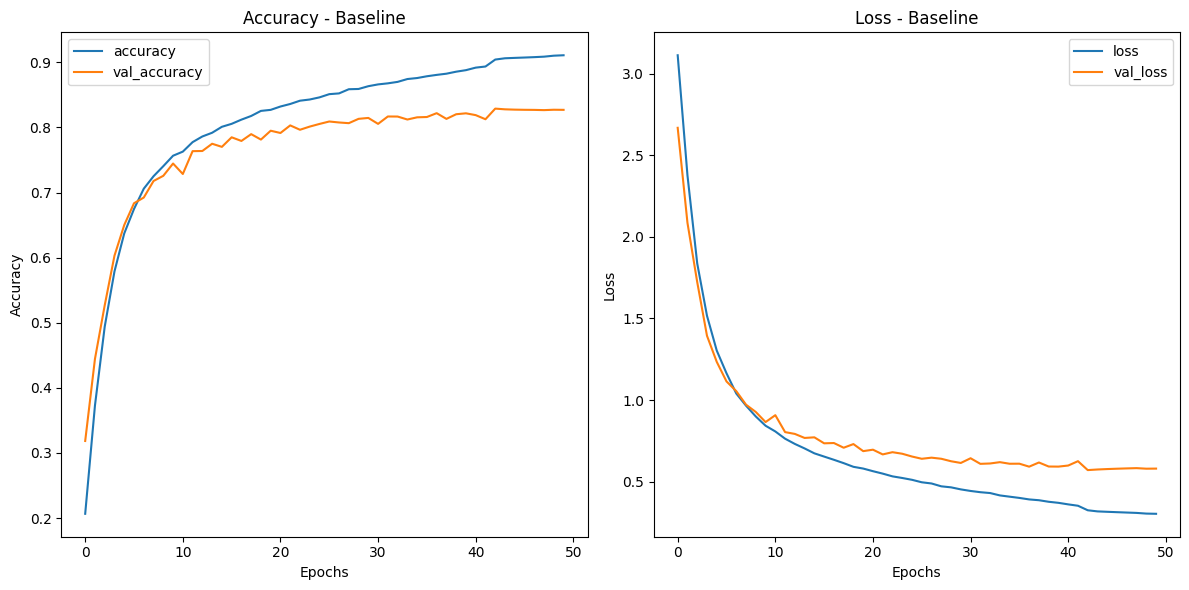

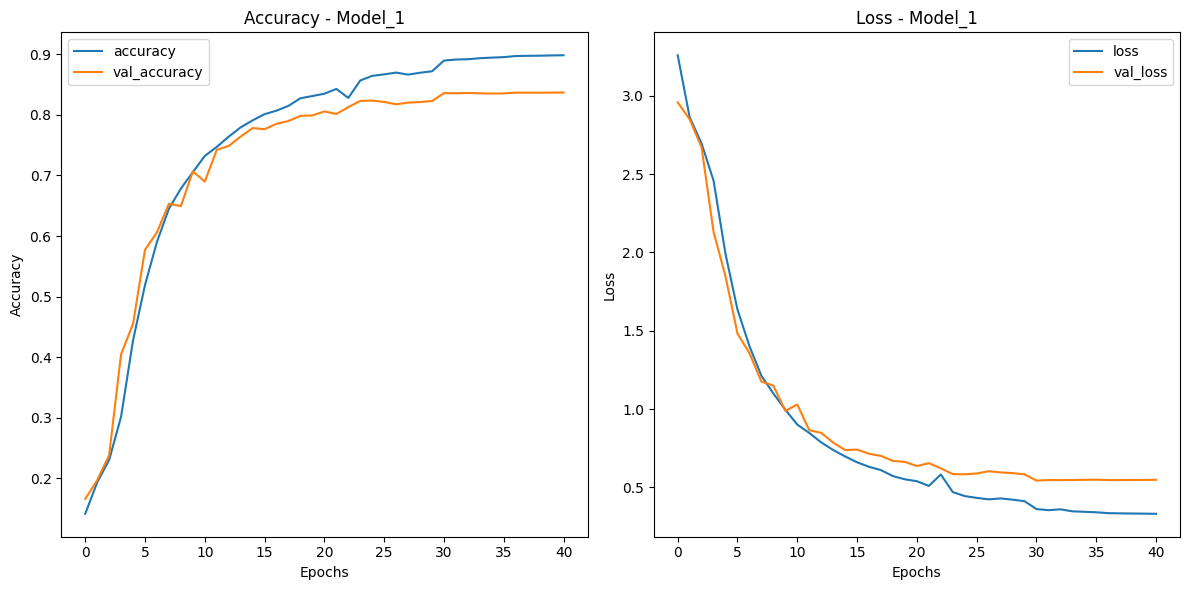

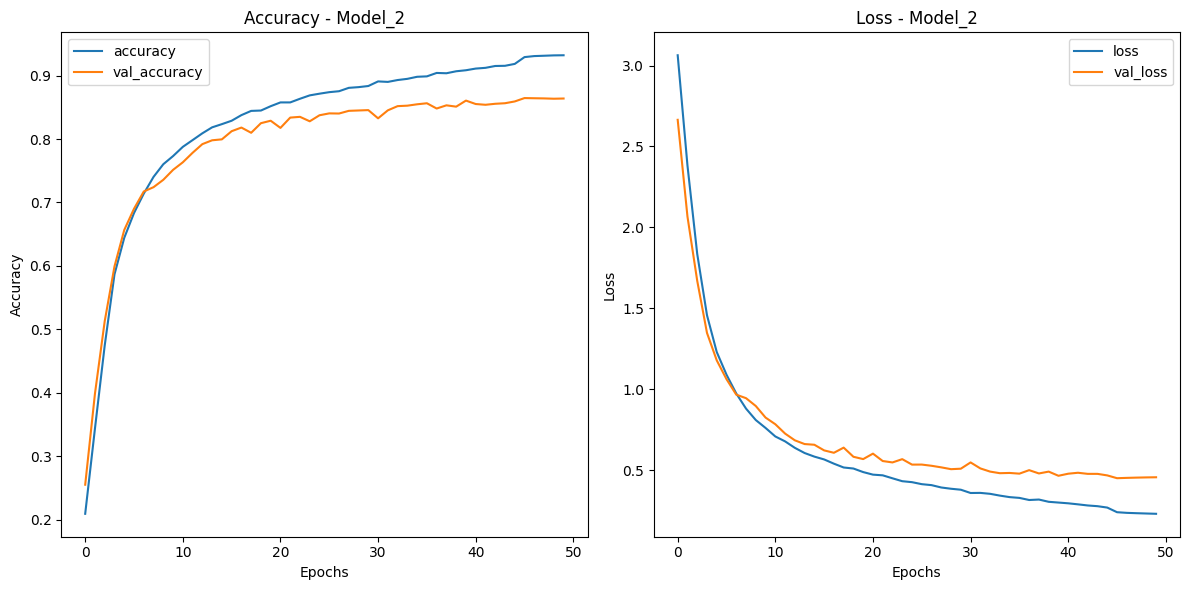

Baseline: Train Accuracy: 0.9110 - Val Accuracy: 0.8271
Model 1 : Train Accuracy: 0.8986 - Val Accuracy: 0.8371
Model 2 : Train Accuracy: 0.9321 - Val Accuracy: 0.8639


In [33]:
train_accuracy, val_accuracy = dict(), dict()
i=0
for model in trained_models[0:12:4]:
    metrics_dict = trained_metrics_dict_test[trained_models.index(model)]
    cm = trained_cm_test[trained_models.index(model)]
    history = trained_history[trained_models.index(model)]
    graph_plots(history, model.name)

    train_accuracy[i], val_accuracy[i] = history['accuracy'][-1], history['val_accuracy'][-1]
    i += 1

print("Baseline: Train Accuracy: {:.4f} - Val Accuracy: {:.4f}".format(train_accuracy[0], val_accuracy[0]))
print("Model 1 : Train Accuracy: {:.4f} - Val Accuracy: {:.4f}".format(train_accuracy[1], val_accuracy[1]))
print("Model 2 : Train Accuracy: {:.4f} - Val Accuracy: {:.4f}".format(train_accuracy[2], val_accuracy[2]))

### Check robustness of the models
From the graph plotted below we can easily see that all the three models are robust. In fact, for each model we trained the model fixing 4 different seeds. As we can see, regardless of the seed, macro-f1 grow steady for every model. 

In [34]:
def check_robustness_model(list_models, list_metrics_dict, metric='macro_f1'):
    
    plt.figure(figsize=(18, 6))
    for i in [0, 1, 2]:
        plt.subplot(1, 3, i+1)
        model_name = list_models[len(seeds)*i].name
        plt.title(f"{model_name} - {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric}")
        for seed in seeds:
            model = list_models[i*len(seeds):(i+1)*len(seeds)][seeds.index(seed)]
            metrics_dict = list_metrics_dict[list_models.index(model)]
            mean_metric = np.mean(list(metrics_dict[metric].values()), axis=0)
            plt.plot(mean_metric, label= f"{seed}")
        plt.legend()

    plt.tight_layout()
    plt.show()

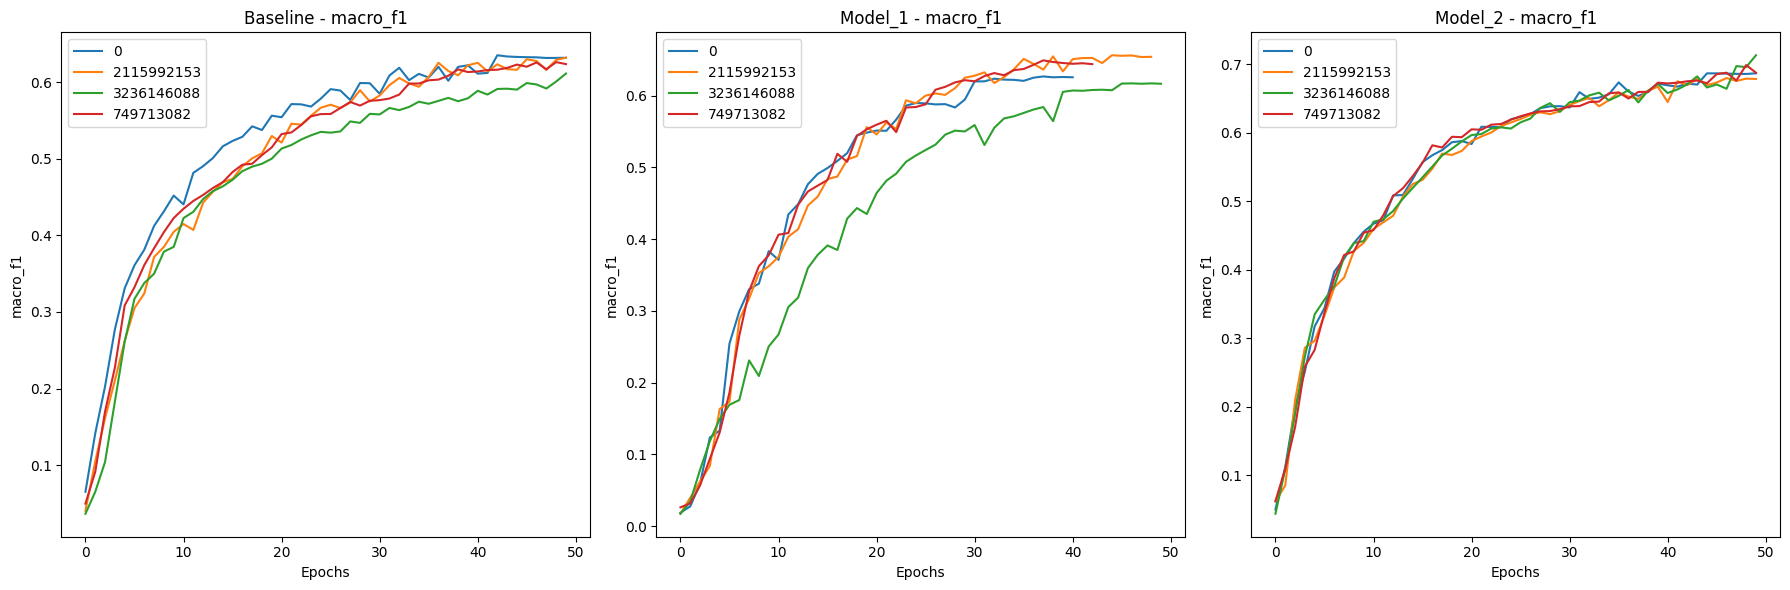

In [35]:
check_robustness_model(trained_models, trained_metrics_dict_val)

### Evaluate the models and find the best one
We evaluate the three models and compare them across the 4 metrics defined: f1, precision, recall and accuracy. In particular for every metric we calculate the mean over the 34 pos classes without punctuation (macro f1 ecc.). <br>
We choose to compare the models over the first seed simply because the baseline model on the first seed ends around epoch 40.

In [36]:
def check_best_model(list_models, list_metrics_dict, seed=0):
    idx_seed = seeds.index(seed)
    keys = list(list_metrics_dict[0].keys())[:-1]
    models_to_check = [list_models[i+idx_seed] for i in range(0, len(list_models), len(seeds))]
    
    plt.figure(figsize=(18, 6))
    for metric in keys:
        i = keys.index(metric)
        plt.subplot(1, 3, i+1)
        
        plt.title(f"Metric: {metric}")
        plt.xlabel("Epochs")
        plt.ylabel(f"{metric}")
        for model in models_to_check:
            metrics_dict = list_metrics_dict[list_models.index(model)]
            mean_metric = np.mean(list(metrics_dict[metric].values()), axis=0) # mean of all the metrics
            plt.plot(mean_metric, label=f'{model.name}')
        plt.legend()

    plt.tight_layout()
    plt.show()

In [37]:
seed_nr = 1
for i in range(3):
    model = trained_models[seed_nr+i*len(seeds)]
    model_metrics = dict()
    for key in trained_metrics_dict_val[0].keys():
        model_metrics[key] = np.mean([trained_metrics_dict_val[seed_nr+i*len(seeds)][key][pos][-1] for pos in list_of_pos if pos not in ignore_classes])
    print(model.name+": Val macro-f1: {:.4f}  - Val precision: {:.4f} - Val recall: {:.4f}".format(model_metrics['macro_f1'], model_metrics['precision'], model_metrics['recall']))

Baseline: Val macro-f1: 0.6323  - Val precision: 0.6593 - Val recall: 0.6171
Model_1: Val macro-f1: 0.6540  - Val precision: 0.6878 - Val recall: 0.6456
Model_2: Val macro-f1: 0.6789  - Val precision: 0.7120 - Val recall: 0.6772


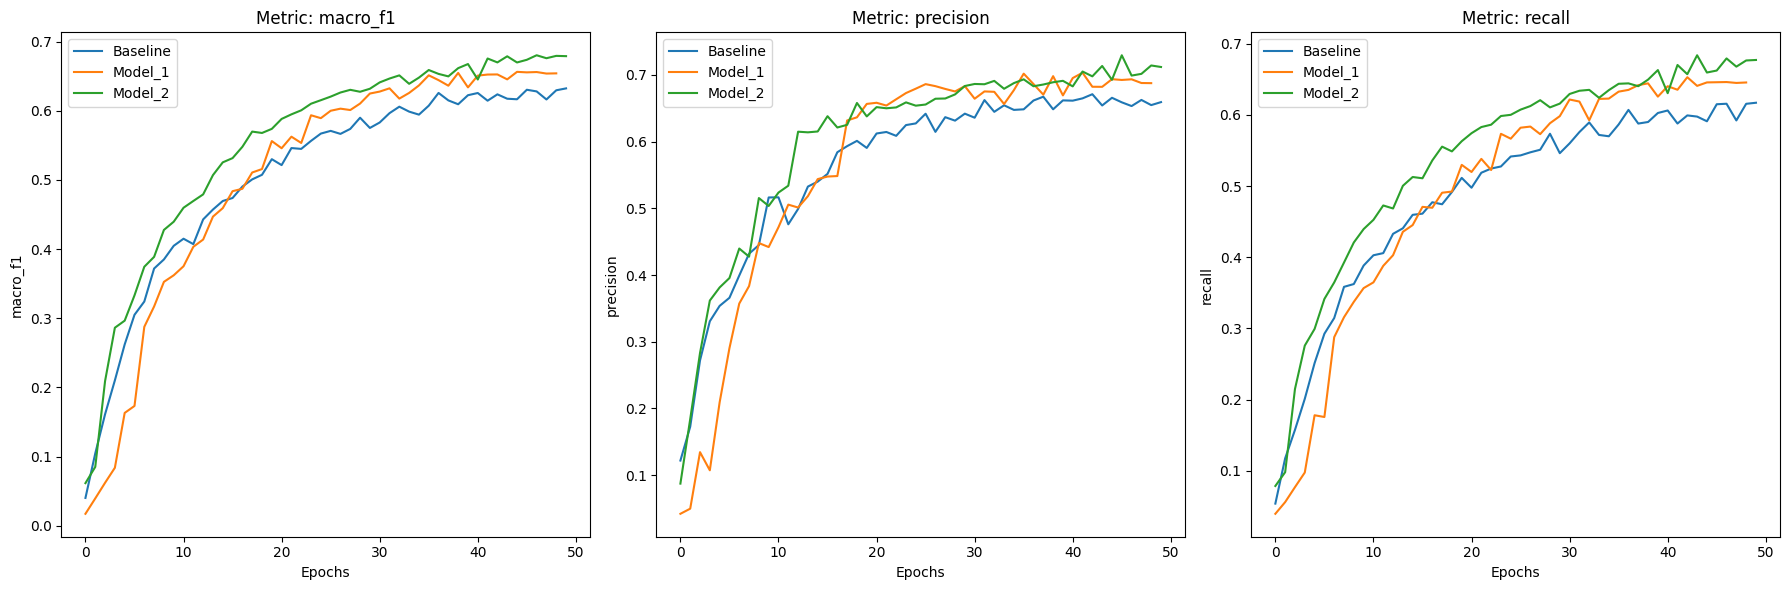

In [38]:
check_best_model(trained_models, trained_metrics_dict_val, seed=seeds[seed_nr])

Even if the difference in the performances of the models is little the best model is Model_2, the one with 2 LSTM layer and a dense layer.

In [39]:
seed_nr = 2 
best_model = globals()['Model_2_'+str(seeds[seed_nr])]
print(f"Best model: {best_model.name} with seed {seeds[seed_nr]}")

Best model: Model_2 with seed 3236146088


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

In [40]:
metrics_dict = trained_metrics_dict_test[trained_models.index(best_model)]
metrics_dict_val = trained_metrics_dict_val[trained_models.index(best_model)]
cm = trained_cm_test[trained_models.index(best_model)]

In [41]:
pred = best_model.predict(x_test_pad)
p = rand_gen.integers(0, len(x_test))
len_of_phrase = len(x_test[p])
print(f"Random phrase: {decode_phrase(x_test[p])}")
print(f"True POS     : {int_to_pos(y_test[p])}")
print(f"Predicted POS: {int_to_pos(pred[p][0:len_of_phrase])}")

21/21 [==============================] - 5s 162ms/step
Random phrase: the second patent describes bone morphogenetic [UNK] , a substance that can induce formation of new cartilage .
True POS     : ['DT', 'JJ', 'NN', 'VBZ', 'NN', 'JJ', 'NN', ',', 'DT', 'NN', 'WDT', 'MD', 'VB', 'NN', 'IN', 'JJ', 'NN', '.']
Predicted POS: ['DT', 'JJ', 'NN', 'VBZ', 'NNP', 'NNP', 'NNP', ',', 'DT', 'NN', 'WDT', 'MD', 'VB', 'NN', 'IN', 'JJ', 'NN', '.']


In [51]:
test_scores = best_model.evaluate(x_test_pad, y_test_pad)


21/21 [==============================] - 3s 150ms/step - loss: 0.3927 - accuracy: 0.8805
Test loss: 0.3926798701286316 - Test accuracy: 0.8805403709411621


In [43]:
model_metrics = dict()

for key in metrics_dict_val.keys():
    model_metrics[key] = np.mean([metrics_dict_val[key][pos][-1] for pos in list_of_pos if pos not in ignore_classes])
print("Model 2 on Validation set: macro-f1: {:.4f}  - precision: {:.4f} - recall: {:.4f}".format(model_metrics['macro_f1'], model_metrics['precision'], model_metrics['recall']))

for key in metrics_dict.keys():
    model_metrics[key] = np.mean([metrics_dict[key][pos][-1] for pos in list_of_pos if pos not in ignore_classes])
print("Model 2 on Test set      : macro-f1: {:.4f}  - precision: {:.4f} - recall: {:.4f}".format(model_metrics['macro_f1'], model_metrics['precision'], model_metrics['recall']))

Model 2 on Validation set: macro-f1: 0.7135  - precision: 0.7522 - recall: 0.7090
Model 2 on Test set      : macro-f1: 0.7017  - precision: 0.7250 - recall: 0.6932


### Performance on most/less frequent classes across the training

In [44]:
def mf_lf_plots(mf_metrics_dict, lf_metrics_dict):
    keys = list(mf_metrics_dict.keys())
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Most Frequent POS')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    for metric in keys:
        mean_metric = np.mean(list(mf_metrics_dict[metric].values()), axis=0)
        plt.plot(mean_metric, label=metric)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Least Frequent POS')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    for metric in keys:
        mean_metric = np.mean(list(lf_metrics_dict[metric].values()), axis=0)
        plt.plot(mean_metric, label=metric)
    plt.legend()

    plt.tight_layout()
    plt.show()

Most frequent tags:  [('NN', 6270), ('NNP', 5202), ('IN', 4952), ('DT', 4076), ('NNS', 3004), ('JJ', 2992), ('VBD', 1548), ('RB', 1490)]
Less frequent tags:  [('UH', 1), ('FW', 2), ('WP$', 6), ('PDT', 9), ('LS', 10), ('RBS', 19), ('EX', 49), ('RBR', 86)]


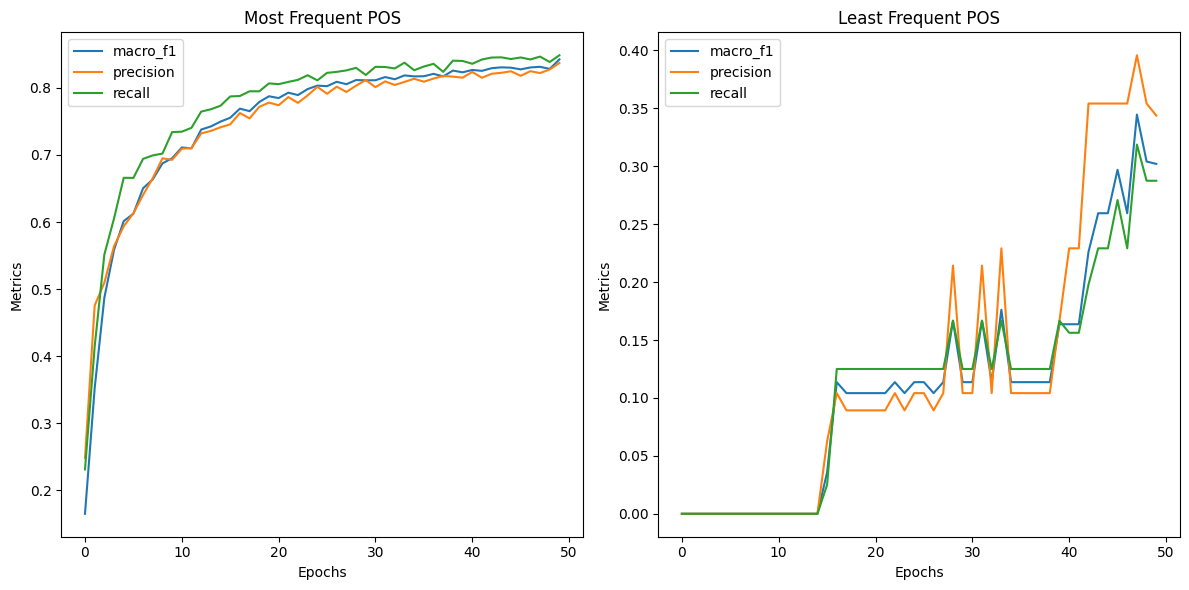

In [45]:
y_train_pos = [ [pos for pos in df_train[df_train['phrase_id']==nr_phrase]['pos']] for nr_phrase in set(df_train['phrase_id']) ]
y_train_pos_flat = [tag for phrase in y_train_pos for tag in phrase]
y_train_pos_clean = [tag for tag in y_train_pos_flat if tag not in ignore_classes]
mf_tags = sorted(set(y_train_pos_clean), key=y_train_pos_clean.count, reverse=True)[:8]
lf_tags = sorted(set(y_train_pos_clean), key=y_train_pos_clean.count)[:8]

mf_metrics_dict = {'macro_f1': {tag: metrics_dict['macro_f1'][tag] for tag in mf_tags},
                   'precision': {tag: metrics_dict['precision'][tag] for tag in mf_tags},
                   'recall': {tag: metrics_dict['recall'][tag] for tag in mf_tags}
                   }

lf_metrics_dict = {'macro_f1': {tag: metrics_dict['macro_f1'][tag] for tag in lf_tags},
                   'precision': {tag: metrics_dict['precision'][tag] for tag in lf_tags},
                   'recall': {tag: metrics_dict['recall'][tag] for tag in lf_tags}
                   }

print("Most frequent tags: ", [(tag, y_train_pos_clean.count(tag)) for tag in mf_tags])
print("Less frequent tags: ", [(tag, y_train_pos_clean.count(tag)) for tag in lf_tags])

mf_lf_plots(mf_metrics_dict, lf_metrics_dict)

### Precision/Recall curves <br>

In [46]:
from sklearn.metrics import (precision_recall_curve, PrecisionRecallDisplay)
import warnings

def flat(dataset):
    return [tag for phrase in dataset for tag in phrase]

def one_vs_all(y_true, y_pred, score_pred, tag):
    Y_test = [1 if tag == y_true[i] else 0 for i in range(len(y_true))]
    Y_pred = [score_pred[i] if tag == y_pred[i] else 0 for i in range(len(y_pred))]

    return Y_test, Y_pred
    
def plot_precision_recall_curve(y_true, y_pred):
    Y_test, Y_pred = dict(), dict()
    pos_tags_sorted = sorted(set(y_train_pos_clean), key=y_train_pos_clean.count, reverse=True)
    ignore_classes = ['[PAD]', '#', '``', '-RRB-', "''", '$', 'SYM', ':', '.', ',', '-LRB-']
    good_classes = [pos for pos in pos_tags_sorted if pos not in ignore_classes]

    pos_pred = [int_to_pos(phrase) for phrase in y_pred]
    flat_y_test = flat([int_to_pos(phrase) for phrase in y_true])
    flat_pos_pred = flat(pos_pred)
    flat_score_pred = [np.dot(y_pred[i][j],y_true[i][j]) for i in range(len(y_pred)) for j in range(len(y_pred[i]))]

    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(15):
        tag = good_classes[i]
        Y_test[i], Y_pred[i] = one_vs_all(flat_y_test, flat_pos_pred, flat_score_pred, tag)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            PrecisionRecallDisplay.from_predictions(Y_test[i], Y_pred[i], name=tag, ax=ax)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Most Frequent tags: Precision-Recall Curve")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(15,34):
        tag = good_classes[i]
        Y_test[i], Y_pred[i] = one_vs_all(flat_y_test, flat_pos_pred, flat_score_pred, tag)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            PrecisionRecallDisplay.from_predictions(Y_test[i], Y_pred[i], name=tag, ax=ax)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Least Frequent tags: Precision-Recall Curve")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [47]:
ignore_classes = ['[PAD]', '#', '``', '-RRB-', "''", '$', 'SYM', ':', '.', ',', '-LRB-']
ignore_classes_num = [pos_to_int(pos) for pos in ignore_classes]

y_test_good = [ [y_test_pad[i][j] for j in range(len(y_test_pad[i])) if y_test_pad[i][j] not in ignore_classes_num] for i in range(len(y_test_pad))]
pred_good = [ [pred[i][j] for j in range(len(pred[i])) if y_test_pad[i][j] not in ignore_classes_num] for i in range(len(pred))]

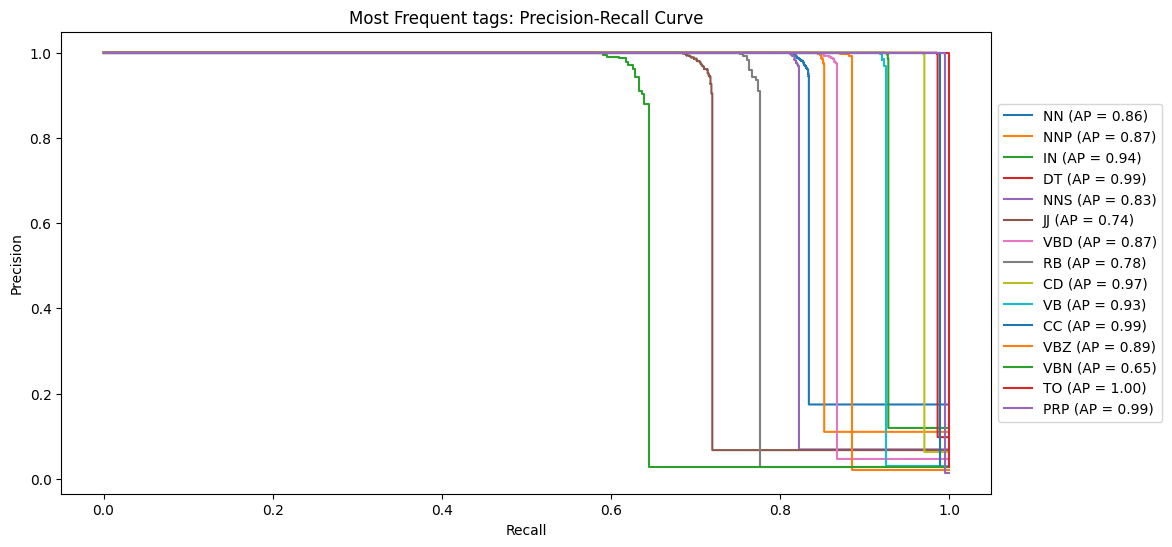

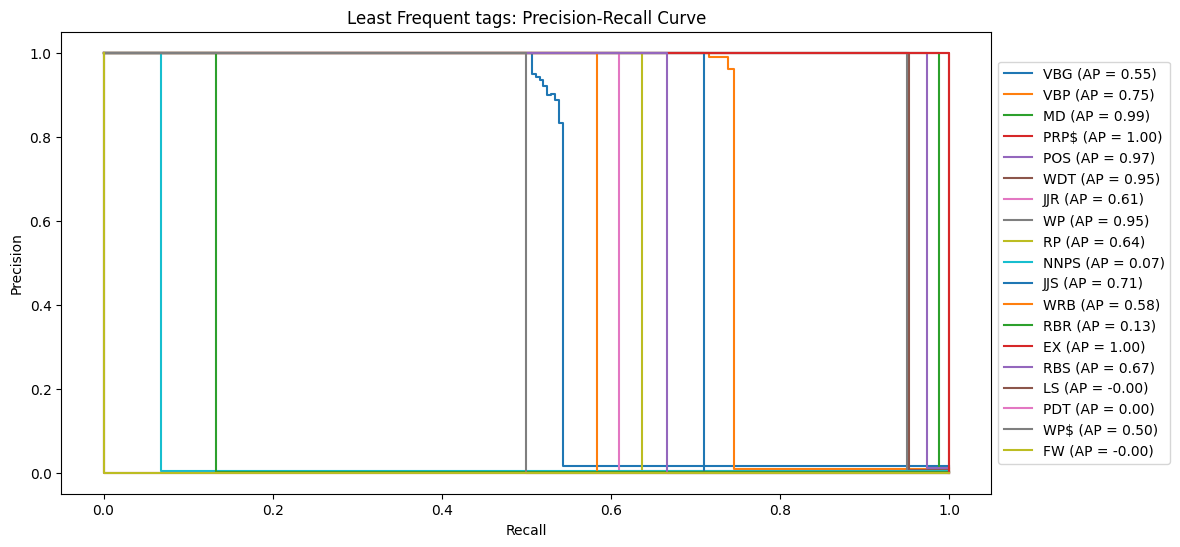

In [48]:
plot_precision_recall_curve(y_test_good, pred_good)

### Confusion matrices

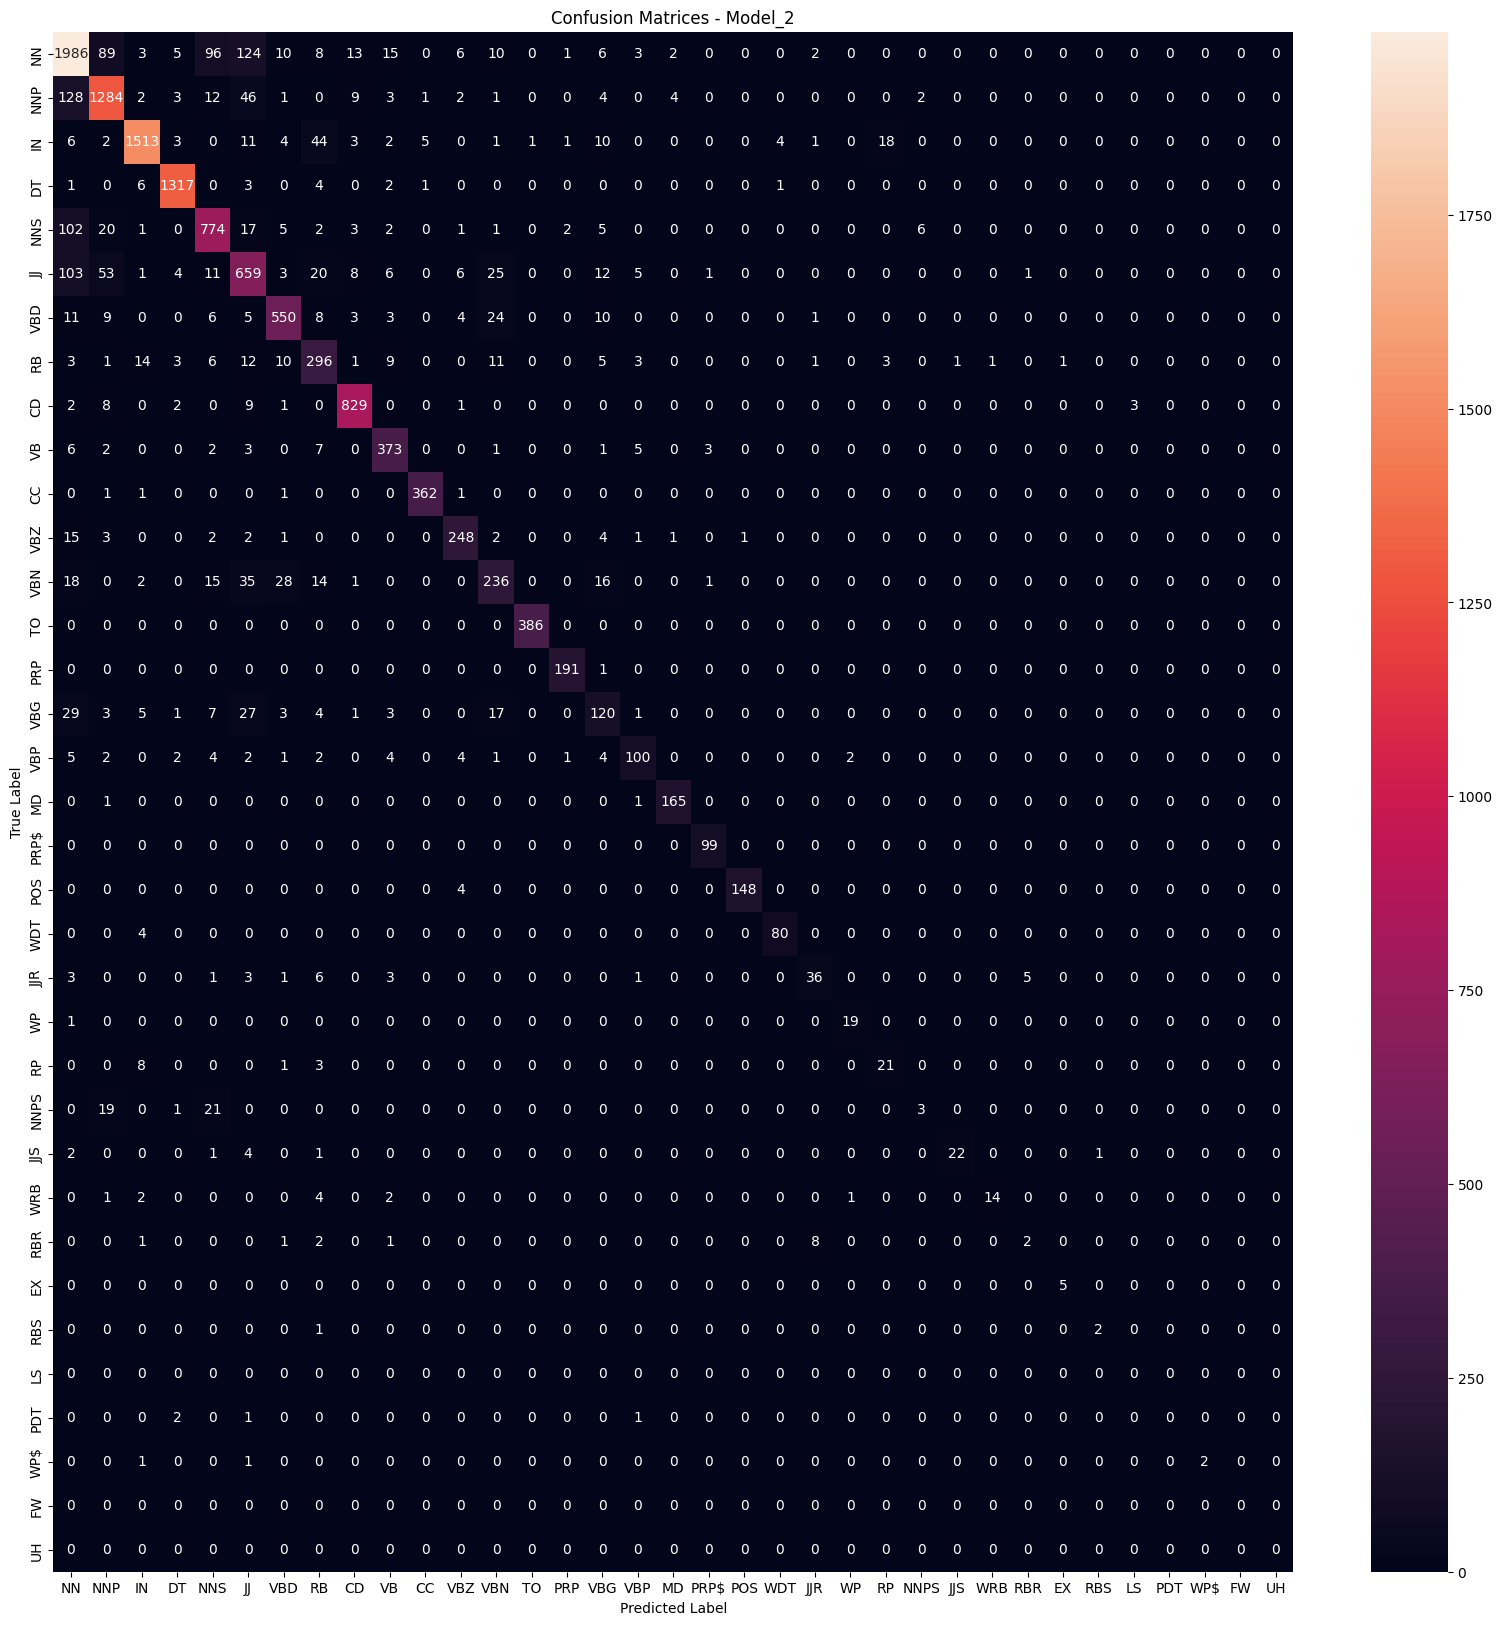

In [49]:
pos_tags = [pos for pos in list_of_pos if pos not in ignore_classes]

pos_tags_sorted = sorted(set(y_train_pos_clean), key=y_train_pos_clean.count, reverse=True)
cm_sorted = cm[[pos_tags.index(tag) for tag in pos_tags_sorted]][:, [pos_tags.index(tag) for tag in pos_tags_sorted]]

plt.figure(figsize=(20, 20))
sns.heatmap(cm_sorted, annot=True, fmt='d', xticklabels=pos_tags_sorted, yticklabels=pos_tags_sorted)
plt.title('Confusion Matrices - ' + model.name)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Specific misclassified samples

From the Confusion matrices we can see that there are some specific set of pos that are easily misclassified, in particular:
- NN / NNP / NNS / JJ are easily misclassified by the model
- VBD, RB, VBN and VBG are easily misclassified in general
- MD, PRP and POS almost perfectly classified
- the following classes in the matrix are so rare that their classification is quite random and usually is hugely affected by misclassification with similar classes that have a most frequent pos, we saw this in both the plot *most/least frequent pos* and the *PR-curves*. A great example is NNPS that is strongly misclassified with NNP and NNS.

In [50]:
print("example with errors between NN/NNS and RB/EX:")
p = 9
len_of_phrase = len(x_test[p])
print(f"Phrase: {decode_phrase(x_test[p])}")
print(f"True POS     : {int_to_pos(y_test[p])}")
print(f"Predicted POS: {int_to_pos(pred[p][0:len_of_phrase])} \n")

print("example with errors between RB/VBN/VBD:")
p = 14
len_of_phrase = len(x_test[p])
print(f"Phrase: {decode_phrase(x_test[p])}")
print(f"True POS     : {int_to_pos(y_test[p])}")
print(f"Predicted POS: {int_to_pos(pred[p][0:len_of_phrase])} \n")

example with errors between NN/NNS and RB/EX:
Phrase: john f. barrett , 40 , formerly executive vice president and chief financial officer , was named president and chief operating officer , posts which had been vacant .
True POS     : ['NNP', 'NNP', 'NNP', ',', 'CD', ',', 'RB', 'JJ', 'NN', 'NN', 'CC', 'NN', 'JJ', 'NN', ',', 'VBD', 'VBN', 'NN', 'CC', 'NN', 'VBG', 'NN', ',', 'NNS', 'WDT', 'VBD', 'VBN', 'JJ', '.']
Predicted POS: ['NNP', 'NNP', 'NNP', ',', 'CD', ',', 'RB', 'JJ', 'NN', 'NN', 'CC', 'NN', 'NNP', 'NN', ',', 'VBD', 'VBN', 'NN', 'CC', 'NN', 'VBG', 'NN', ',', 'NNS', 'WDT', 'VBD', 'VBN', 'VBN', '.'] 

example with errors between RB/VBN/VBD:
Phrase: and some investment bankers say a restructuring is n't feasible while the sec still is scrutinizing mr. spiegel 's past junk-bond trades .
True POS     : ['CC', 'DT', 'NN', 'NNS', 'VBP', 'DT', 'NN', 'VBZ', 'RB', 'JJ', 'IN', 'DT', 'NNP', 'RB', 'VBZ', 'VBG', 'NNP', 'NNP', 'POS', 'JJ', 'NN', 'NNS', '.']
Predicted POS: ['CC', 'DT', 'NN', '


| [The Penn Treebank POS tagset](https://catalog.ldc.upenn.edu/docs/LDC95T7/cl93.html)  | | | | | |
|--|--|--|--|--|--|
| CC  Coordinating conjunction               | JJS Adjective, superlative | <span style="color:green">POS</span> Possessive ending  | TO  to | WDT wh-determiner | :  Colon, semi-colon 
| CD  Cardinal number                        | LS  List item marker       | <span style="color:green">PRP</span> Personal pronoun    | UH  Interjection   | WP  wh-pronoun | (  Left bracket character 
| DT  Determiner                             | <span style="color:green">MD</span>  Modal | PP  Possessive pronoun  | VB  Verb, base form | WP  Possessive wh-pronoun | )  Right bracket character
| EX  Existential there  	                 | <span style="color:yellow">NN</span>  Noun, singular or mass     | <span style="color:orange">RB</span>  Adverb    | <span style="color:orange">VBD</span> Verb, past tense | WRB wh-adverb  | "  Straight double quote 
| FW  Foreign word                           | <span style="color:yellow">NNS</span> Noun, plural  | RBR Adverb, comparative      | <span style="color:orange">VBG</span> Verb, gerund/present participle | \#  Pound sign | `  Left open single quote
| IN  Preposition/subord. 218z conjunction   | <span style="color:yellow">NNP</span> Proper noun, singular  | RBS Adverb, superlative  | <span style="color:orange">VBN</span> Verb, past participle | $  Dollar sign | "  Left open double quote 
| <span style="color:yellow">JJ</span>  Adjective                              | <span style="color:yellow">NNPS</span> Proper noun, plural | RP  Particle  | VBP Verb, non-3rd ps. sing. present | .  Sentence-final punctuation | '  Right close single quote 
| JJR Adjective, comparative                 | PDT Predeterminer           | SYM Symbol  | VBZ Verb, 3rd ps. sing. present | ,  Comma | "  Right close double quote
 

In the table above we have a full description of the POS tagset, as we can see by the description of the various tagset many classes have little differences from one another. In particular we can try to find out the reason of the principal errors mentioned before:
- <span style="color:yellow">NN / NNP / NNS / NNPS / JJ</span> are classes that can be easily misclassified for two different reasons:
    - NN / NNP / NNS / NNPS are classes (nouns) with so similar meaning that for the model is difficult to learn the differences.
    - JJ are adjectives that can be easily misclassified with nouns in english.
- <span style="color:orange">VBD / RB / VBN / VBG</span> are classes (verbs and adverbs) with so similar meaning that for the model is difficult to learn the differences. VBN and VBG are tagset that can be misclassified even with nouns and adjectives because of their particular tense (past participle and gerund/present participle).
- <span style="color:green">MD / PRP / POS </span> are almost perfectly classified because they are very particular tagset that are easy to classify. It's important to observe that our dataset doesn't contain all classes mentioned above, and in particular it doesn't contain class PP which could be misclassiified with POS.

### Possible solutions

At the end of the error analysis we came up with some possible solution to prevent some of the most frequent errors, in particular we organize our possible solutions in the different part of the process.
- Embedding:
    - in order to reduce the number of OOV word in training, validation and test set could be used a bigger pre-trained embedding set. In fact, with [Glove wiki 50](https://nlp.stanford.edu/data/glove.6B.zip) in the training set we had 4.85% of OOV terms which receive a random vector as their embedding vector. This inevitably lead to errors due to incapability of the model to understand the essence of OOV tokens in training, validation and test set. <br>
    Here are some pre-trained word vectors that from [Stanford site](https://nlp.stanford.edu/projects/glove/) that have more vocab than Glove wiki (400k vocab): [Common Crawl](https://nlp.stanford.edu/data/glove.840B.300d.zip) (2.2M vocab) and [Twitter](https://nlp.stanford.edu/data/glove.twitter.27B.zip) (1.2M vocab).
    - if we still want to use Glove wiki, could be used a higher dimensional Glove embedding such as Glove 300 in order to better represent the essence of each token.
    - in order to better define OOV vector in the training set, we could divide the training into two parts: in the first one we could fix the embedding layer of the model and let the other layers train, after many epochs we could unfix the embedding layer in order to better reshape the vectors related to OOV terms.
- Training:
    - as we saw in the plot comparing the training of the most and least frequent tokens it's probable that a longer training session could benefit those pos classes that are less frequent.
    - we could try to find a loss function that better represents our goal, for example a macro accuracy with a low bias for classes that will be later ignore in the f1 score.
- Substantial changes:
    - As we saw that many classes are strictly related maybe could be better to join them together and divide the classification in two parts: the first one where the model classifies the tokens into general classes and the second where another model try to detect the correct subclass. For example we could create a new class "verb" that join together all verbs classes, than the model should firstly understand if the token is a verb and only after try to choose across the specific classes (VB, VBD, VBG...).
    

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End